# **Sonuçlar**

Burada verilen bilgilerin ayrıntıları kodda mevcuttur. Model istenilen gibi 4 epoch eğitilmiştir ve en iyi sonucu alacak şekilde parametreler optimize edilmiştir. Model eğitiminde daha başarılı olması için sağlıksız beyin verilerinin labelları kullanılmıştır. Bu labellara göre 128x128 patch'ler alınmıştır. Sağlıklı beyin verilerinde ise label bulunmadığından beyin bölgesinden patch alınmıştır. Eğitim sırasında edinilen bilgiler ve eğitim sonrası test sonuçları aşağıda resimlerle özetlenmiştir.

Aynı veri ve tekniklere epoch sayısını arttırdığım zaman test veri setinde çok daha yüksek oranda doğru sonuç alındığı görülmüştür

# 4 Epoch Eğitim Test Sonuçları

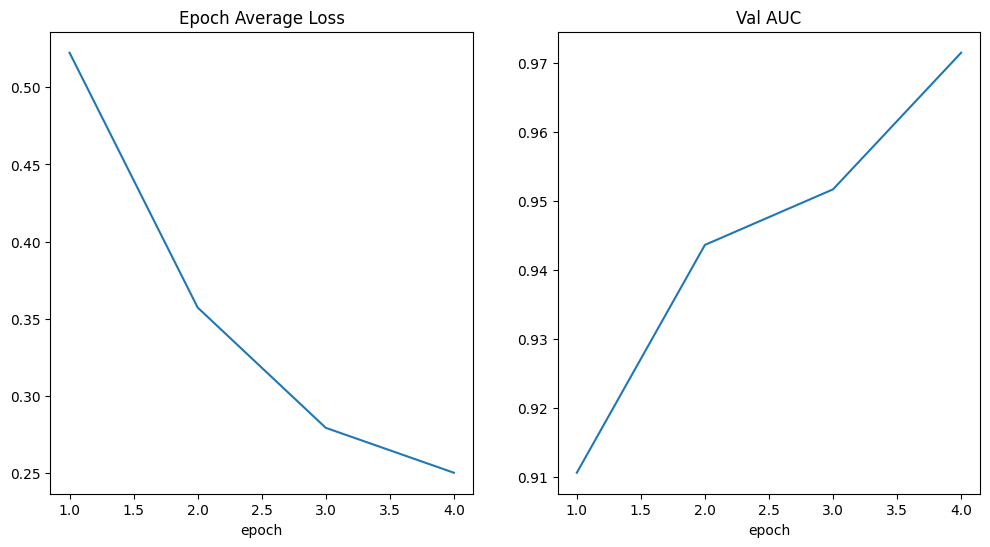

- Test Sonuçları

Test Accuracy: 0.9352 (4 Epoch)

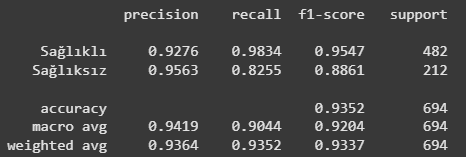

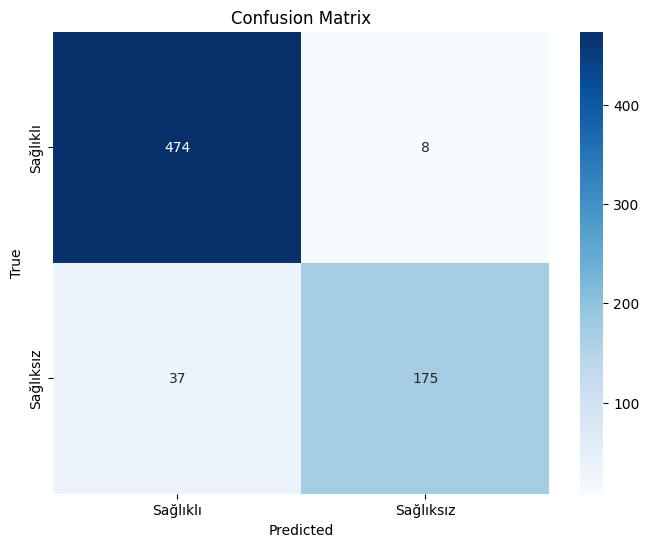

# Kütüphaneleri import et

In [ ]:
!pip install monai -q

import os
import shutil
import tempfile
import matplotlib.pyplot as plt
import PIL
import torch
from torch.utils.tensorboard import SummaryWriter
import numpy as np
from sklearn.metrics import classification_report

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import decollate_batch, Dataset, DataLoader
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.transforms import (
    Activations,
    AsDiscrete,
    Compose,
    LoadImaged,
    EnsureChannelFirstd,
    ScaleIntensityd,
    Resized,
    ToTensord,
    MapTransform,
    RandFlipd,
    RandRotated
)
from monai.utils import set_determinism
import cv2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 41.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 81.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 38.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 95.9 MB/s eta 0:00:00


# Veriyi Yükle

In [ ]:
# !pip install rarfile -q

# import gdown
# import rarfile
# import os

# # Dosya ID'si ve hedef dosya adı
# file_id = "1fyqO-phKJ6umFUv-pJH5VzZyfANnzfhe"
# output_file = "/content/drive/MyDrive/Colab Notebooks/Biyomedikal/2.Quiz/data/BeyinInmeVerisi.rar"
# extract_folder = "/content/drive/MyDrive/Colab Notebooks/Biyomedikal/2.Quiz/data/BeyinInmeVerisi"

# # Google Drive'dan dosyayı indir
# gdown.download(f"https://drive.google.com/uc?id={file_id}", output_file, quiet=False)

# # RAR dosyasını çıkart
# if not os.path.exists(extract_folder):
#     os.makedirs(extract_folder)

# with rarfile.RarFile(output_file) as rf:
#     rf.extractall(extract_folder)

# print(f"Dosya '{output_file}' indirildi ve '{extract_folder}' klasörüne çıkarıldı.")

# Seed belirleyerek deterministik eğitimi etkinleştirin

In [ ]:
set_determinism(seed=42)

# Veri kümesi klasörlerinden görüntü dosya adlarını okuma

In [ ]:
import os
from glob import glob
import PIL


# Görüntülerin ve maskelerin bulunduğu klasörler
healthy_img_dir = "/content/drive/MyDrive/Colab Notebooks/Biyomedikal/2.Quiz/data/BeyinInmeVerisi/0"
unhealthy_img_dir = "/content/drive/MyDrive/Colab Notebooks/Biyomedikal/2.Quiz/data/BeyinInmeVerisi/1"
healthy_label_dir = ""   # Sağlıklı verilerin label'ları (maskeleri)
unhealthy_label_dir = "/content/drive/MyDrive/Colab Notebooks/Biyomedikal/1.Quiz/data/BeyinInmeVerisi-Bolutleme/masks"

data = []

# Sağlıklı veriler (label: 0)
healthy_images = sorted(glob(os.path.join(healthy_img_dir, "*.png")))
for img_path in healthy_images:
    filename = os.path.basename(img_path)
    # Eğer healthy mask klasörü varsa, karşılık gelen mask'i kontrol et
    if os.path.isdir(healthy_label_dir):
        mask_path = os.path.join(healthy_label_dir, filename)
        if not os.path.exists(mask_path):
            mask_path = None
    else:
        mask_path = None
    data.append({
        "image": img_path,
        "mask": mask_path,   # Sağlıklı verilerde mask olmayabilir; ya None ya da dummy mask verilebilir.
        "label": 0
    })

# Sağlıksız veriler (label: 1)
unhealthy_images = sorted(glob(os.path.join(unhealthy_img_dir, "*.png")))
for img_path in unhealthy_images:
    filename = os.path.basename(img_path)
    if os.path.isdir(unhealthy_label_dir):
        mask_path = os.path.join(unhealthy_label_dir, filename)
        if not os.path.exists(mask_path):
            mask_path = None
    else:
        mask_path = None
    data.append({
        "image": img_path,
        "mask": mask_path,
        "label": 1
    })

# Veri setinizin özetini kontrol edelim:
num_total = len(data)
example_image = PIL.Image.open(data[0]["image"])
image_width, image_height = example_image.size

print(f"Total image count: {num_total}")
print(f"Image dimensions: {image_width} x {image_height}")
print("Örnek veri öğesi:", data[5000])


Total image count: 6947
Image dimensions: 512 x 512
Örnek veri öğesi: {'image': '/content/drive/MyDrive/Colab Notebooks/Biyomedikal/2.Quiz/data/BeyinInmeVerisi/1/11279.png', 'mask': '/content/drive/MyDrive/Colab Notebooks/Biyomedikal/1.Quiz/data/BeyinInmeVerisi-Bolutleme/masks/11279.png', 'label': 1}


# Görselleştirmek ve kontrol etmek için veri kümesinden rastgele resimler seçin

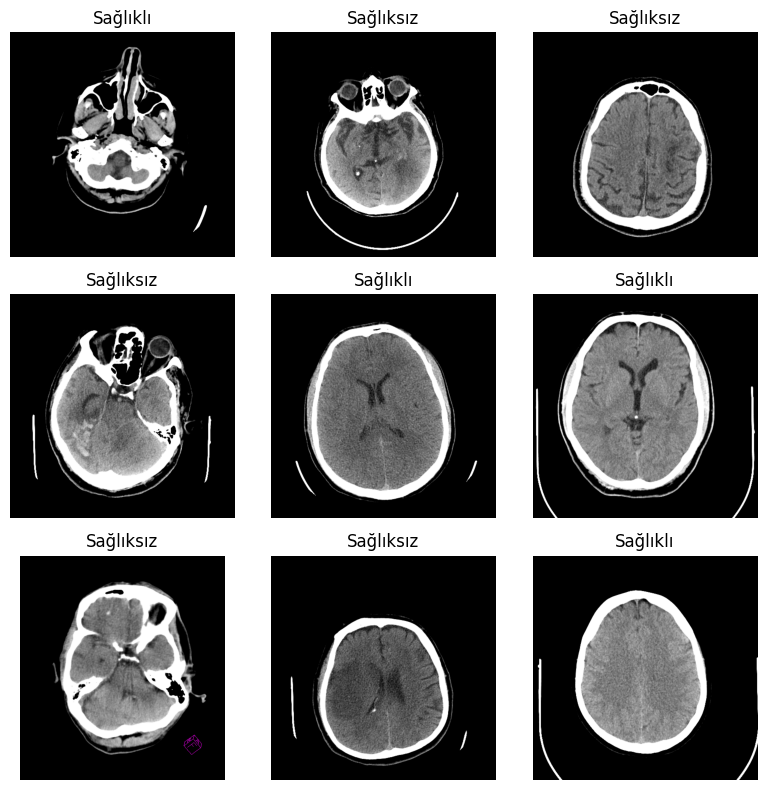

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL

# Sınıf isimlerini tanımlayalım (isteğe bağlı)
class_names = ["Sağlıklı", "Sağlıksız"]

fig, axes = plt.subplots(3, 3, figsize=(8, 8))
axes = axes.flatten()

for ax in axes:
    # data listesinden rastgele bir örnek seçelim
    k = np.random.randint(0, len(data))
    # Resim yolunu alıp resmi yükleyelim
    img_path = data[k]["image"]
    img = PIL.Image.open(img_path)
    arr = np.array(img)

    # Resmi gri tonlamalı olarak gösteriyoruz
    ax.imshow(arr, cmap="gray", vmin=0, vmax=255)
    # Sınıf etiketini başlık olarak ekleyelim
    ax.set_title(class_names[data[k]["label"]])
    ax.axis("off")  # Eksenleri gizleyelim

plt.tight_layout()
plt.show()


# Eğitim, doğrulama ve test veri listelerini hazırlayın
Veri setinin %10'unu doğrulama, %10'unu da test olarak rastgele seçin.


In [ ]:
import numpy as np

val_frac = 0.1
test_frac = 0.1
length = len(data)
indices = np.arange(length)
np.random.shuffle(indices)

test_split = int(test_frac * length)
val_split = int(val_frac * length) + test_split

test_indices = indices[:test_split]
val_indices = indices[test_split:val_split]
train_indices = indices[val_split:]

train_data = [data[i] for i in train_indices]
val_data = [data[i] for i in val_indices]
test_data = [data[i] for i in test_indices]

print(f"Training count: {len(train_data)}, Validation count: {len(val_data)}, Test count: {len(test_data)}")


Training count: 5559, Validation count: 694, Test count: 694


# Verileri önceden işlemek için MONAI dönüşümlerini, Dataset ve Dataloader'ı tanımlama

In [ ]:
# Özel bir dönüşüm tanımlayarak unhealthy bölgeden patch çıkaralım.
class ExtractPatchd(MapTransform):
    """
    Sağlıksız (label==1) verilerde, maskeyi kullanarak unhealthy bölgenin etrafından belirli boyutlarda patch çıkarır.
    Eğer veri sağlıklı ise veya maske yoksa, görüntünün center crop'unu alır.
    Beklenen veri sözlüğü: {"image": image_tensor, "mask": mask_tensor, "label": int}
    """
    def __init__(self, keys, patch_size):
        """
        :param keys: Uygulanacak anahtarlar, örneğin ["image", "mask", "label"]
        :param patch_size: Çıkarılacak patch boyutu, örn: (128, 128)
        """
        super().__init__(keys)
        self.patch_size = patch_size

    def __call__(self, data):
        d = dict(data)
        image = d["image"]  # beklenen shape: (C, H, W)
        mask = d.get("mask", None)
        label = d.get("label", 0)  # default olarak 0 kabul edilir

        patch_h, patch_w = self.patch_size

        # Sağlıksız görüntü ise, maskeye göre patch çıkar.
        if mask is not None and label == 1:
            # Maskenin tensor veya numpy array olup olmadığını kontrol et.
            if isinstance(mask, torch.Tensor):
                mask_np = mask.numpy()
            else:
                mask_np = mask
            # Varsayalım maskenin shape'i (1, H, W) ve unhealthy bölge mask değeri > 0
            coords = np.argwhere(mask_np[0] > 0)
            if coords.shape[0] > 0:
                y_min, x_min = coords.min(axis=0)
                y_max, x_max = coords.max(axis=0)
                center_y = (y_min + y_max) // 2
                center_x = (x_min + x_max) // 2
                half_h = patch_h // 2
                half_w = patch_w // 2
                start_y = max(center_y - half_h, 0)
                start_x = max(center_x - half_w, 0)
                # Eğer görüntü sınırlarını aşıyorsa, kırpma yapılır.
                patch = image[:, start_y : start_y + patch_h, start_x : start_x + patch_w]
                d["image"] = patch
                return d

        # Sağlıklı verilerde veya mask yoksa center crop uygulayalım.
        C, H, W = image.shape
        half_h = patch_h // 2
        half_w = patch_w // 2
        center_y = H // 2
        center_x = W // 2
        start_y = max(center_y - half_h, 0)
        start_x = max(center_x - half_w, 0)
        patch = image[:, start_y : start_y + patch_h, start_x : start_x + patch_w]
        d["image"] = patch
        return d


In [ ]:
# Eğer resimlerinizi OpenCV ile grayscale yükleyip, MONAI dönüşümleriyle devam etmek isterseniz,
# basit bir helper fonksiyon kullanarak resim yolunu numpy array'e çevirebilirsiniz.
def load_grayscale_cv2(img_path):
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # tek kanal olarak okur
    if image is None:
        raise ValueError(f"Dosya okunamadı: {img_path}")
    image = np.expand_dims(image, axis=0)  # (H, W) -> (1, H, W)
    return image.astype(np.float32)

In [ ]:
# Özel load fonksiyonu tanımlıyoruz.
class LoadGrayscaleD(MapTransform):
    def __call__(self, data):
        d = dict(data)
        img_path = d["image"]
        d["image"] = load_grayscale_cv2(img_path)
        # Eğer mask yolu varsa, grayscale yükleyip, mask olarak ekleyelim.
        mask_path = d.get("mask", None)
        if mask_path is not None:
            d["mask"] = load_grayscale_cv2(mask_path)
        else:
            # Sağlıklı veriler için sıfır maskesi (boyut: (1, H, W))
            # Burada önceden belirlenmiş bir boyut kullanıyoruz;
            # Resize dönüşümü sonrasında uygun hale gelecektir.
            dummy = np.zeros((1, 256, 256), dtype=np.float32)
            d["mask"] = dummy
        return d

In [ ]:
# Eğitim için dönüşüm pipeline'ı
train_transforms = Compose([
    LoadGrayscaleD(keys=["image", "mask"]),
    # Görüntü ve maskeye kanal eklenmiş hali zaten (1, H, W) olduğundan eklemeye gerek yok,
    # fakat Resize, ScaleIntensity vb. uygulanıyor.
    ScaleIntensityd(keys=["image"]),
    Resized(keys=["image", "mask"], spatial_size=(512, 512)),
    ToTensord(keys=["image", "mask"]),
    ExtractPatchd(keys=["image", "mask", "label"], patch_size=(128, 128)),
])

# Doğrulama dönüşümleri (rastgele augmentasyonlar olmadan)
val_transforms = Compose([
    LoadGrayscaleD(keys=["image", "mask"]),
    ScaleIntensityd(keys=["image"]),
    Resized(keys=["image", "mask"], spatial_size=(512, 512)),
    ToTensord(keys=["image", "mask"]),
    ExtractPatchd(keys=["image", "mask", "label"], patch_size=(128, 128)),
])

y_pred_trans = Compose([Activations(softmax=True)])
y_trans = Compose([AsDiscrete(to_onehot=2)])

In [ ]:
import torch
from torch.utils.data import DataLoader
from monai.data import Dataset
from monai.transforms import Compose

# Yeni dataset sınıfı; her öğe bir dictionary olduğundan, dönüşüm uygulandıktan sonra "image" ve "label" döndürülüyor.
class BrainStrokeDataset(torch.utils.data.Dataset):
    def __init__(self, data, transforms):
        """
        :param data: Dictionary'lerden oluşan veri listesi. Her öğe aşağıdaki gibi:
                     {"image": image_path, "mask": mask_path or None, "label": int}
        :param transforms: MONAI dönüşüm pipeline'ı (örneğin, train_transforms, val_transforms)
        """
        self.data = data
        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        # Veriye dönüşüm pipeline'ını uygula.
        d = self.transforms(self.data[index])
        # Eğitim için genellikle "image" ve "label" yeterli olur.
        return d["image"], d["label"]


# MONAI dönüşüm pipeline'ınızı (patch çıkarma da dahil) tanımladığınızı varsayalım:
# Örneğin, train_transforms ve val_transforms

# Eğitim veri seti ve DataLoader
train_ds = BrainStrokeDataset(train_data, train_transforms)
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=8)

# Doğrulama veri seti ve DataLoader
val_ds = BrainStrokeDataset(val_data, val_transforms)
val_loader = DataLoader(val_ds, batch_size=16, shuffle=False, num_workers=8)

# Test veri seti ve DataLoader (doğrulama dönüşümleri ile)
test_ds = BrainStrokeDataset(test_data, val_transforms)
test_loader = DataLoader(test_ds, batch_size=16, shuffle=False, num_workers=8)


# Eğitim veri seti özet bilgileri

In [ ]:
print("Eğitim veri seti özet bilgileri:")
print(f"Toplam örnek sayısı: {len(train_ds)}")

# Son 10 örneğin boyutlarını kontrol edelim
shapes = []
print("\nSon 10 örneğin detayları:")
for i in range(len(train_ds) - 10, len(train_ds)):
    image, label = train_ds[i]
    shapes.append(image.shape)
    print(f"Örnek {i}: Görüntü boyutu: {image.shape}, Label: {label}")

# Eğer tüm örneklerin boyutları aynıysa bunu belirtelim
unique_shapes = set(shapes)
if len(unique_shapes) == 1:
    print(f"\nTüm örnekler tutarlı boyutta: {shapes[0]}")
else:
    print("\nFarklı görüntü boyutları bulundu:", unique_shapes)


Eğitim veri seti özet bilgileri:
Toplam örnek sayısı: 5559

Son 10 örneğin detayları:
Örnek 5549: Görüntü boyutu: torch.Size([1, 128, 128]), Label: 1
Örnek 5550: Görüntü boyutu: torch.Size([1, 128, 128]), Label: 0
Örnek 5551: Görüntü boyutu: torch.Size([1, 128, 128]), Label: 1
Örnek 5552: Görüntü boyutu: torch.Size([1, 128, 128]), Label: 1
Örnek 5553: Görüntü boyutu: torch.Size([1, 128, 128]), Label: 0
Örnek 5554: Görüntü boyutu: torch.Size([1, 128, 128]), Label: 0
Örnek 5555: Görüntü boyutu: torch.Size([1, 128, 128]), Label: 1
Örnek 5556: Görüntü boyutu: torch.Size([1, 128, 128]), Label: 1
Örnek 5557: Görüntü boyutu: torch.Size([1, 128, 128]), Label: 1
Örnek 5558: Görüntü boyutu: torch.Size([1, 128, 128]), Label: 0

Tüm örnekler tutarlı boyutta: torch.Size([1, 128, 128])


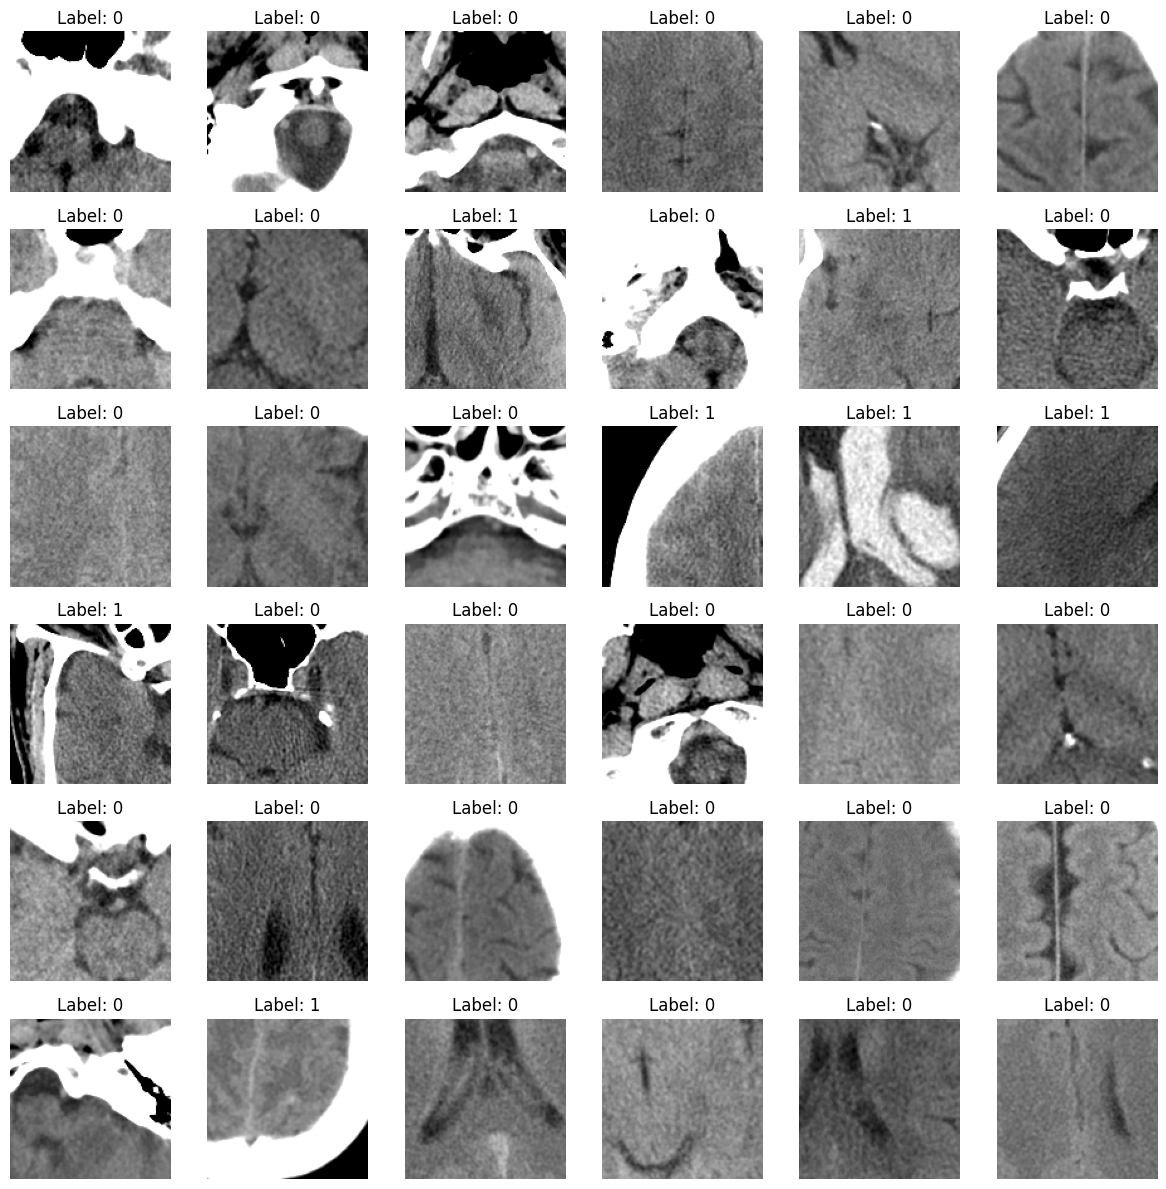

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# 36 örnek toplamak için
num_samples = 36
images_list = []
labels_list = []

# Dataset'in doğrudan indekslenebildiğini varsayıyoruz.
for i in range(num_samples):
    image, label = train_ds[i]  # train_ds, dönüşüm uygulanmış tuple (image, label) döndürür.
    images_list.append(image)
    labels_list.append(label)

# Tüm görüntüleri bir tensor haline getirelim ve numpy array'e çevirelim
images_tensor = torch.stack(images_list, dim=0)  # shape: (36, C, H, W)
images_np = images_tensor.cpu().numpy()
labels_np = torch.tensor(labels_list).cpu().numpy()

# 6x6 grid oluşturuyoruz
fig, axes = plt.subplots(6, 6, figsize=(12, 12))
axes = axes.flatten()

# Her bir alt grafiğe örnek görüntü ve etiket ekleyelim.
for i in range(num_samples):
    ax = axes[i]
    # Tek kanallı görüntü olduğundan, 0. kanalı alıyoruz.
    img = images_np[i, 0, :, :]
    ax.imshow(img, cmap="gray", vmin=0, vmax=1)
    ax.set_title(f"Label: {labels_np[i]}")
    ax.axis("off")

# Eğer gridde boş kalan alt grafik varsa kapatıyoruz.
for j in range(num_samples, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


# Network ve Optimizer'ı Tanımla (4 Epoch Eğitim için)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DenseNet121(spatial_dims=2, in_channels=1, out_channels=2).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)
max_epochs = 4
val_interval = 1
auc_metric = ROCAUCMetric()

# Model eğitimi (4 Epoch Eğitim için)

In [ ]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
        epoch_len = len(train_ds) // train_loader.batch_size
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data[0].to(device),
                    val_data[1].to(device),
                )
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join("/content/drive/MyDrive/Colab Notebooks/Biyomedikal/2.Quiz", "model4.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
            writer.add_scalar("val_accuracy", acc_metric, epoch + 1)

print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")
writer.close()

----------
epoch 1/4
1/347, train_loss: 0.6976
2/347, train_loss: 0.6757
3/347, train_loss: 0.6992
4/347, train_loss: 0.6814
5/347, train_loss: 0.6573
6/347, train_loss: 0.6952
7/347, train_loss: 0.6480
8/347, train_loss: 0.6886
9/347, train_loss: 0.7266
10/347, train_loss: 0.6824
11/347, train_loss: 0.6634
12/347, train_loss: 0.6420
13/347, train_loss: 0.6454
14/347, train_loss: 0.6427
15/347, train_loss: 0.7144
16/347, train_loss: 0.6811
17/347, train_loss: 0.6257
18/347, train_loss: 0.6394
19/347, train_loss: 0.6492
20/347, train_loss: 0.6405
21/347, train_loss: 0.6533
22/347, train_loss: 0.6423
23/347, train_loss: 0.6190
24/347, train_loss: 0.6289
25/347, train_loss: 0.6310
26/347, train_loss: 0.6251
27/347, train_loss: 0.6114
28/347, train_loss: 0.6392
29/347, train_loss: 0.6327
30/347, train_loss: 0.6466
31/347, train_loss: 0.6164
32/347, train_loss: 0.6331
33/347, train_loss: 0.5930
34/347, train_loss: 0.6035
35/347, train_loss: 0.6411
36/347, train_loss: 0.6169
37/347, train_lo

 # Plot the loss and metric (4 Epoch Eğitim için)

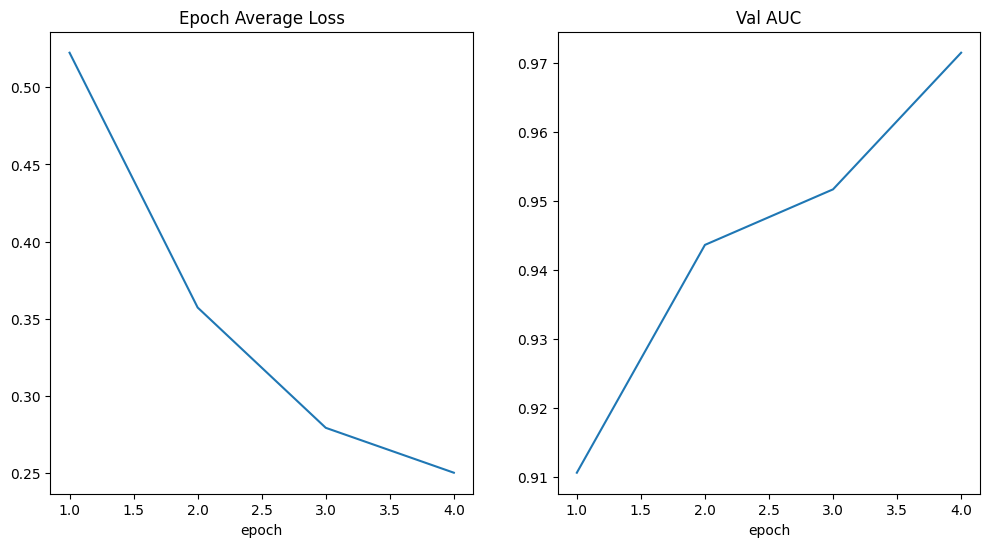

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

# Modeli test veri kümesinde değerlendirin (4 Epoch Eğitim için)

In [ ]:
model.load_state_dict(torch.load(os.path.join("/content/drive/MyDrive/Colab Notebooks/Biyomedikal/2.Quiz", "model4.pth")))
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data[0].to(device),
            test_data[1].to(device),
        )
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

<ipython-input-18-9bb38456ffcb>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join("/content/drive/MyDrive/Colab Notebooks/Biyome

In [ ]:
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

              precision    recall  f1-score   support

    Sağlıklı     0.9276    0.9834    0.9547       482
   Sağlıksız     0.9563    0.8255    0.8861       212

    accuracy                         0.9352       694
   macro avg     0.9419    0.9044    0.9204       694
weighted avg     0.9364    0.9352    0.9337       694



# Modeli test veri kümesi üzerinde çalıştırıp ortalama test accuracy skorunu hesaplama (4 Epoch Eğitim için)

In [ ]:
model.eval()  # Modeli değerlendirme moduna al
test_correct = 0
test_total = 0

with torch.no_grad():
    for batch_data in test_loader:
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        outputs = model(inputs)
        # Tahmin edilen sınıfı almak için argmax kullanılır
        predicted = torch.argmax(outputs, dim=1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.4f}")


Test Accuracy: 0.9352


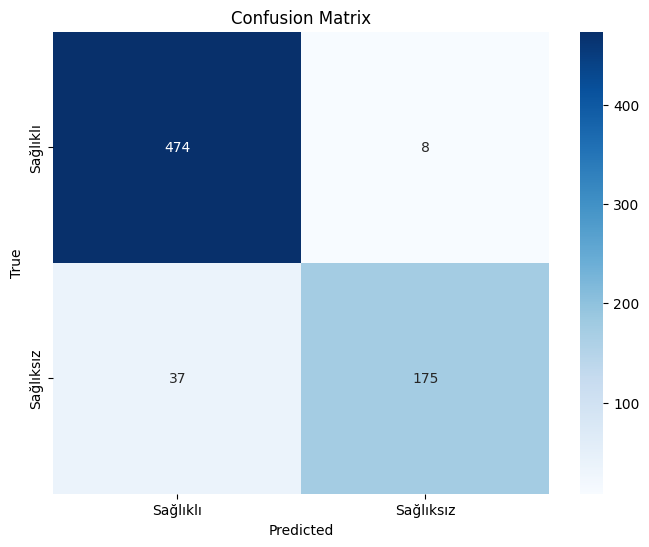

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming y_true and y_pred are already defined from your previous code
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


# **=====================================================================================**

In [ ]:
# Eğitim veri seti ve DataLoader
train_ds = BrainStrokeDataset(train_data, train_transforms)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=8)

# Doğrulama veri seti ve DataLoader
val_ds = BrainStrokeDataset(val_data, val_transforms)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=8)

# Test veri seti ve DataLoader (doğrulama dönüşümleri ile)
test_ds = BrainStrokeDataset(test_data, val_transforms)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=8)

# Network ve Optimizer'ı Tanımla (10 Epoch Eğitim için)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DenseNet121(spatial_dims=2, in_channels=1, out_channels=2).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)
max_epochs = 10
val_interval = 1
auc_metric = ROCAUCMetric()

# Model eğitimi (10 Epoch Eğitim için)

In [ ]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()

from tqdm import tqdm
import time

for epoch in range(max_epochs):
    print(f"\nEpoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0

    # Create a progress bar for training
    pbar = tqdm(total=len(train_ds) // train_loader.batch_size, desc="Training", unit="batch")

    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

        # Update progress bar with loss
        pbar.set_postfix({"loss": f"{loss.item():.4f}"})
        pbar.update(1)

        # Add to tensorboard
        epoch_len = len(train_ds) // train_loader.batch_size
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)

    pbar.close()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)

    # Print epoch summary
    print(f"Epoch {epoch + 1} Summary:")
    print(f"└── Average Loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        print("Validating...")

        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)

            # Create a progress bar for validation
            val_pbar = tqdm(total=len(val_loader), desc="Validation", unit="batch")

            for val_data in val_loader:
                val_images, val_labels = (
                    val_data[0].to(device),
                    val_data[1].to(device),
                )
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
                val_pbar.update(1)

            val_pbar.close()

            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)

            saved_new = False
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join("/content/drive/MyDrive/Colab Notebooks/Biyomedikal/2.Quiz", "model2.pth"))
                saved_new = True

            # Print validation summary
            print(f"Validation Summary (Epoch {epoch + 1}):")
            print(f"└── AUC: {result:.4f}")
            print(f"└── Accuracy: {acc_metric:.4f}")
            print(f"└── Best AUC: {best_metric:.4f} (Epoch {best_metric_epoch})")
            if saved_new:
                print(f"└── ✓ Saved new best model")

            writer.add_scalar("val_accuracy", acc_metric, epoch + 1)

print(f"\nTraining completed!")
print(f"└── Best AUC: {best_metric:.4f} (Epoch {best_metric_epoch})")
writer.close()


Epoch 1/10


Training: 174batch [00:50,  3.43batch/s, loss=0.3751]


Epoch 1 Summary:
└── Average Loss: 0.5459
Validating...


Validation: 100%|██████████| 22/22 [00:04<00:00,  5.26batch/s]


Validation Summary (Epoch 1):
└── AUC: 0.8861
└── Accuracy: 0.8213
└── Best AUC: 0.8861 (Epoch 1)
└── ✓ Saved new best model

Epoch 2/10


Training: 174batch [00:30,  5.70batch/s, loss=0.5064]


Epoch 2 Summary:
└── Average Loss: 0.3889
Validating...


Validation: 100%|██████████| 22/22 [00:04<00:00,  5.03batch/s]


Validation Summary (Epoch 2):
└── AUC: 0.9320
└── Accuracy: 0.8689
└── Best AUC: 0.9320 (Epoch 2)
└── ✓ Saved new best model

Epoch 3/10


Training: 174batch [00:31,  5.56batch/s, loss=0.1601]


Epoch 3 Summary:
└── Average Loss: 0.2966
Validating...


Validation: 100%|██████████| 22/22 [00:04<00:00,  5.20batch/s]


Validation Summary (Epoch 3):
└── AUC: 0.9563
└── Accuracy: 0.8934
└── Best AUC: 0.9563 (Epoch 3)
└── ✓ Saved new best model

Epoch 4/10


Training: 174batch [00:30,  5.75batch/s, loss=0.2190]


Epoch 4 Summary:
└── Average Loss: 0.2433
Validating...


Validation: 100%|██████████| 22/22 [00:04<00:00,  5.05batch/s]


Validation Summary (Epoch 4):
└── AUC: 0.9692
└── Accuracy: 0.9193
└── Best AUC: 0.9692 (Epoch 4)
└── ✓ Saved new best model

Epoch 5/10


Training: 174batch [00:30,  5.79batch/s, loss=0.3538]


Epoch 5 Summary:
└── Average Loss: 0.1944
Validating...


Validation: 100%|██████████| 22/22 [00:04<00:00,  5.21batch/s]


Validation Summary (Epoch 5):
└── AUC: 0.9755
└── Accuracy: 0.9294
└── Best AUC: 0.9755 (Epoch 5)
└── ✓ Saved new best model

Epoch 6/10


Training: 174batch [00:30,  5.76batch/s, loss=0.1864]


Epoch 6 Summary:
└── Average Loss: 0.1750
Validating...


Validation: 100%|██████████| 22/22 [00:04<00:00,  5.22batch/s]


Validation Summary (Epoch 6):
└── AUC: 0.9787
└── Accuracy: 0.9395
└── Best AUC: 0.9787 (Epoch 6)
└── ✓ Saved new best model

Epoch 7/10


Training: 174batch [00:30,  5.78batch/s, loss=0.2439]


Epoch 7 Summary:
└── Average Loss: 0.1489
Validating...


Validation: 100%|██████████| 22/22 [00:04<00:00,  5.19batch/s]


Validation Summary (Epoch 7):
└── AUC: 0.9817
└── Accuracy: 0.9294
└── Best AUC: 0.9817 (Epoch 7)
└── ✓ Saved new best model

Epoch 8/10


Training: 174batch [00:29,  5.83batch/s, loss=0.1119]


Epoch 8 Summary:
└── Average Loss: 0.1315
Validating...


Validation: 100%|██████████| 22/22 [00:04<00:00,  5.15batch/s]


Validation Summary (Epoch 8):
└── AUC: 0.9798
└── Accuracy: 0.9409
└── Best AUC: 0.9817 (Epoch 7)

Epoch 9/10


Training: 174batch [00:29,  5.84batch/s, loss=0.1549]


Epoch 9 Summary:
└── Average Loss: 0.1186
Validating...


Validation: 100%|██████████| 22/22 [00:04<00:00,  5.25batch/s]


Validation Summary (Epoch 9):
└── AUC: 0.9829
└── Accuracy: 0.9352
└── Best AUC: 0.9829 (Epoch 9)
└── ✓ Saved new best model

Epoch 10/10


Training: 174batch [00:30,  5.77batch/s, loss=0.0563]


Epoch 10 Summary:
└── Average Loss: 0.1080
Validating...


Validation: 100%|██████████| 22/22 [00:04<00:00,  5.27batch/s]


Validation Summary (Epoch 10):
└── AUC: 0.9833
└── Accuracy: 0.9308
└── Best AUC: 0.9833 (Epoch 10)
└── ✓ Saved new best model

Training completed!
└── Best AUC: 0.9833 (Epoch 10)


 # Plot the loss and metric (10 Epoch Eğitim için)

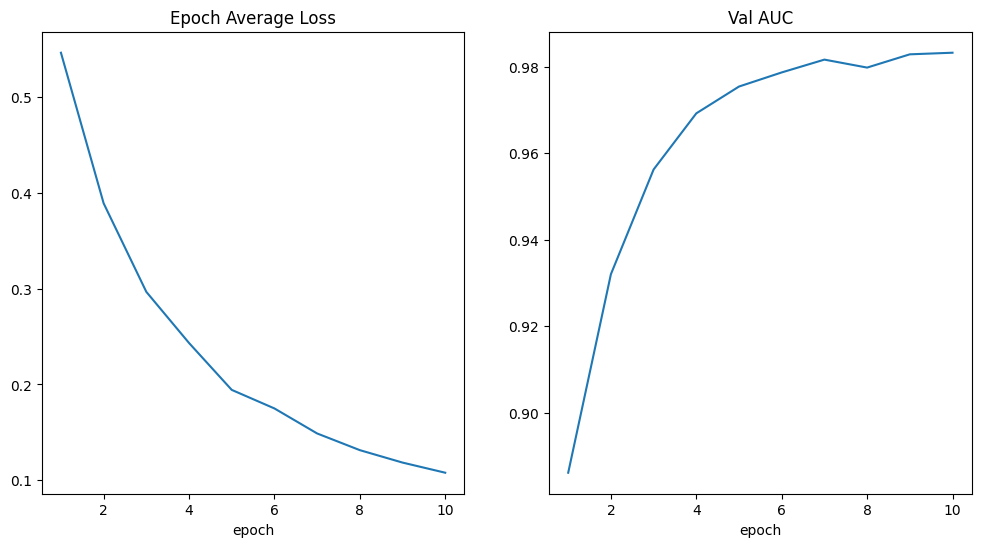

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

# Modeli test veri kümesinde değerlendirin (10 Epoch Eğitim için)

In [ ]:
model.load_state_dict(torch.load(os.path.join("/content/drive/MyDrive/Colab Notebooks/Biyomedikal/2.Quiz", "model2.pth")))
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data[0].to(device),
            test_data[1].to(device),
        )
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

<ipython-input-14-076376e735ad>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join("/content/drive/MyDrive/Colab Notebooks/Biyome

In [ ]:
class_names = ["Sağlıklı", "Sağlıksız"]
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

              precision    recall  f1-score   support

    Sağlıklı     0.9461    0.9834    0.9644       482
   Sağlıksız     0.9585    0.8726    0.9136       212

    accuracy                         0.9496       694
   macro avg     0.9523    0.9280    0.9390       694
weighted avg     0.9499    0.9496    0.9489       694



# Modeli test veri kümesi üzerinde çalıştırıp ortalama test accuracy skorunu hesaplama (10 Epoch Eğitim için)

In [ ]:
model.eval()  # Modeli değerlendirme moduna al
test_correct = 0
test_total = 0

with torch.no_grad():
    for batch_data in test_loader:
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        outputs = model(inputs)
        # Tahmin edilen sınıfı almak için argmax kullanılır
        predicted = torch.argmax(outputs, dim=1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.4f}")


Test Accuracy: 0.9496


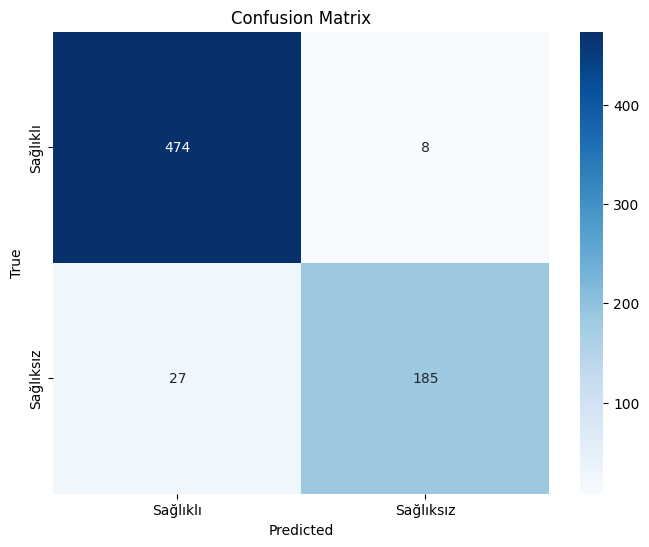

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming y_true and y_pred are already defined from your previous code
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
import torch

model.eval()
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
        outputs = model(test_images)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)  # Get probabilities

        for i in range(len(probabilities)):
            stroke_probability = probabilities[i][1].item() * 100 # Probability of stroke (class 1)
            print(f"Brain data {i+1}: {stroke_probability:.2f}% chance of stroke")


Brain data 1: 91.44% chance of stroke
Brain data 2: 0.04% chance of stroke
Brain data 3: 0.32% chance of stroke
Brain data 4: 0.34% chance of stroke
Brain data 5: 0.32% chance of stroke
Brain data 6: 0.79% chance of stroke
Brain data 7: 39.11% chance of stroke
Brain data 8: 0.21% chance of stroke
Brain data 9: 0.74% chance of stroke
Brain data 10: 0.13% chance of stroke
Brain data 11: 0.90% chance of stroke
Brain data 12: 2.24% chance of stroke
Brain data 13: 4.18% chance of stroke
Brain data 14: 54.71% chance of stroke
Brain data 15: 99.93% chance of stroke
Brain data 16: 99.92% chance of stroke
Brain data 17: 0.10% chance of stroke
Brain data 18: 0.35% chance of stroke
Brain data 19: 6.20% chance of stroke
Brain data 20: 0.72% chance of stroke
Brain data 21: 98.91% chance of stroke
Brain data 22: 99.40% chance of stroke
Brain data 23: 2.64% chance of stroke
Brain data 24: 2.55% chance of stroke
Brain data 25: 0.56% chance of stroke
Brain data 26: 0.12% chance of stroke
Brain data 27: